In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
import madmom
import myutils
import collections
import subprocess
from os.path import basename
import librosa #For audio loading because Essentia kicks up on large file counts

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
import csv

from essentia import *
from essentia.standard import *

from random import shuffle

In [2]:
datasetPath = "/Users/carthach/tmp/drum_timbre/data_new1"
# datasetPath = "/Users/carthach/tmp/general_timbre/selection4"

#Make sure we have a trailing
datasetPath = os.path.join(datasetPath, '', '')

#Get the timbreClasses in datasetPath
timbreClasses = [d for d in os.listdir(datasetPath) if os.path.isdir(os.path.join(datasetPath, d))]

def getInstrumentClasses(datasetPath, timbreClasses):
    instrumentClasses = []
    
    for timbreClass in timbreClasses:
        instrumentPath = datasetPath + timbreClass
        sectionInstrumentClasses = [d for d in os.listdir(instrumentPath) if os.path.isdir(os.path.join(instrumentPath, d))]
        sectionInstrumentClasses = ["%s/%s" % (timbreClass, sectionInstrumentClass) for sectionInstrumentClass in sectionInstrumentClasses]
    
        instrumentClasses += sectionInstrumentClasses
        
    return instrumentClasses
    
instrumentClasses = getInstrumentClasses(datasetPath, timbreClasses)

In [3]:
#Convert an Essentia Pool to a flat Vector
def poolToVector(pool):
    featureVector = []
    
    featureNames = []
    
    for feature in pool.descriptorNames():
        if isinstance(pool[feature], (list, tuple, np.ndarray)):
            for featureScalar in pool[feature]:
                featureVector.append(featureScalar)
        else:
            featureVector.append(pool[feature])
            
        featureNames.append(feature)
            

                                        
    return featureVector, featureNames

#Write out the Pool to Yaml Files
def savePool(filename, pool):
    YamlOutput(filename = filename, writeVersion=False)(pool)
    
#Load a Pool from the Yaml Files    
def loadPool(filename):
    yamlInput = YamlInput(filename=filename)
    
    pool = yamlInput()
    
    return pool

#Load an audio file and extract the features, returning as a pool
def extractFeatures(filename):
    audio, sampleRate = librosa.load(filename, sr=44100)
#     audio, sampleRate = loadAudio(filename)

    # create the pool and the necessary algorithms
    pool = Pool()
    w = Windowing()
    spec = Spectrum()
    centroid = Centroid(range=22050)
    flatness = Flatness()
    flatnessDB = FlatnessDB()
    mfcc = MFCC()
    bfcc = BFCC(
        type = 'power',
#         weighting = 'linear',
        lowFrequencyBound = 40,
        highFrequencyBound = 22050,
        numberBands = 40,
        numberCoefficients = 13,
        normalize = 'unit_max',
        dctType = 2,
        logType = 'dbamp',
        liftering = 22
    )
    gfcc = GFCC()
    loudness = Loudness()
    logAttackTime = LogAttackTime()
    
    spectralPeaks = SpectralPeaks()
    hpcp = HPCP()
        
    # compute the centroid for all frames in our audio and add it to the pool
    for frame in FrameGenerator(audio, frameSize = 1024, hopSize = 512):        
        s = spec(w(frame))
        
        c = centroid(s)
        pool.add('centroid', c)
        
#         f = flatness(s)
        f = flatnessDB(s)        
        pool.add('flatness', f)        

        m_bands, m_coeffs = mfcc(s)
        pool.add('mfcc', m_coeffs)
        
        b_bands, b_coeffs = bfcc(s)
        pool.add('bfcc', b_coeffs)
        
        g_bands, g_coeffs = gfcc(s)
        pool.add('gfcc', g_coeffs)        
        
        specFreqs, specMags = spectralPeaks(s)
        h = hpcp(specFreqs, specMags)
        
        pool.add('hpcp', h)
        
    # aggregate the results
    aggrPool = PoolAggregator(defaultStats = [ 'mean', 'var'])(pool)
    
    l, aStart, aStop = logAttackTime(audio)
    aggrPool.add('logAttackTime', l)
    aggrPool.add('loudness', loudness(audio))
    
    return aggrPool

In [4]:
#Extract all chosen featuress from the sounds in the path, applying the class labels
def analyseSounds(datasetPath, soundClasses, reAnalyse=False, featureSet=[]):
    labels = []
    featuresDict = {}
    
    finalFeatureNames = ""
    
    for soundClass in soundClasses:
        features = []
        
        soundPath = datasetPath + soundClass

        soundFiles = myutils.getListOfFilesRecursive(soundPath, "*.mp3")
        soundFiles += myutils.getListOfFilesRecursive(soundPath, "*.wav")
                
        print("Processing: %s" % soundClass)
        
        for soundFile in soundFiles:
            yamlFile = soundFile + ".yaml"
            
            #Analyse or retrieve yaml features
            if not os.path.isfile(yamlFile) or reAnalyse:            
                featurePool = extractFeatures(soundFile)
                savePool(yamlFile, featurePool)
            else:        
                featurePool = loadPool(yamlFile)
                
            for descriptor in featurePool.descriptorNames():
                if descriptor not in featureSet:
                    featurePool.remove(descriptor)
                                                        
            featureVector, featureNames = poolToVector(featurePool)
            
            features.append(featureVector)
            labels.append(soundClasses.index(soundClass))
            
            finalFeatureNames = featureNames
            
        featuresDict[soundClass] = features
        
    return featuresDict, labels, finalFeatureNames

#Different Feature Configurations
temporalFeatures = ["loudness", "logAttackTime"]
spectralFeatures = ["centroid.mean", "centroid.var", "flatness.mean", "flatness.var"]
mfccFeatures = ["mfcc.mean", "mfcc.var"]
bfccFeatures = ["bfcc.mean", "bfcc.var"]
gfccFeatures = ["gfcc.mean", "gfcc.var"]
hpcpFeatures = ["hpcp.mean", "hpcp.var"]
temporalSpectralFeatures = temporalFeatures + spectralFeatures
mfccTemporalSpectralFeatures = mfccFeatures + temporalSpectralFeatures
bfccTemporalSpectralFeatures = bfccFeatures + temporalSpectralFeatures
gfccTemporalSpectralFeatures = gfccFeatures + temporalSpectralFeatures
mfccTemporalSpectralHarmonicFeatures = mfccFeatures + temporalSpectralFeatures + hpcpFeatures
bfccTemporalSpectralHarmonicFeatures = bfccFeatures + temporalSpectralFeatures + hpcpFeatures
hpcpTemporalSpectralFeatures = hpcpFeatures + temporalSpectralFeatures


#A dictionary of feature combinations to iterate through
featureSets = {
    "Temporal" : temporalFeatures,
    "Spectral" : spectralFeatures,
    "Temporal+Spectral" : temporalSpectralFeatures,
    "MFCC" : mfccFeatures,
    "BFCC" : bfccFeatures,
    "GFCC" : gfccFeatures,    
    "HPCP" : hpcpFeatures,    
    "MFCC+Temporal+Spectral" : mfccTemporalSpectralFeatures,
    "BFCC+Temporal+Spectral" : bfccTemporalSpectralFeatures,
    "GFCC+Temporal+Spectral" : gfccTemporalSpectralFeatures,    
    "HPCP+Temporal+Spectral" : hpcpTemporalSpectralFeatures
}

Processing: cymbals
Processing: perc
Processing: hats
Processing: toms
Processing: claps
Processing: snares
Processing: kicks
['logAttackTime', 'loudness']
Processing: cymbals
Processing: perc
Processing: hats
Processing: toms
Processing: claps
Processing: snares
Processing: kicks
['centroid.mean', 'loudness']
Processing: cymbals
Processing: perc
Processing: hats
Processing: toms
Processing: claps
Processing: snares
Processing: kicks
['flatness.mean', 'loudness']
Processing: cymbals
Processing: perc
Processing: hats
Processing: toms
Processing: claps
Processing: snares
Processing: kicks
['centroid.mean', 'logAttackTime']
Processing: cymbals
Processing: perc
Processing: hats
Processing: toms
Processing: claps
Processing: snares
Processing: kicks
['flatness.mean', 'logAttackTime']
Processing: cymbals
Processing: perc
Processing: hats
Processing: toms
Processing: claps
Processing: snares
Processing: kicks
['centroid.mean', 'flatness.mean']


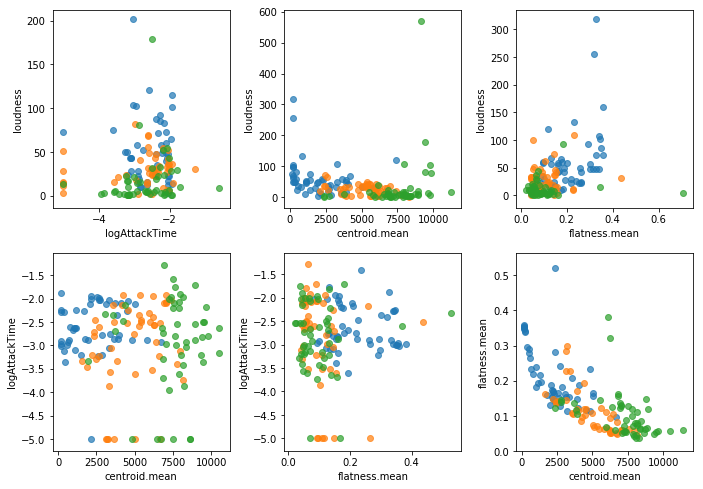

In [23]:
def plotFeatures(features, label):    
    plt.scatter(features[:,0], features[:,1], label=label, alpha=0.7)

def plotFeatureCombination(featureSet, index):
    plt.subplot(index)
    
    featureDict, labels, featureNames = analyseSounds(datasetPath, timbreClasses, reAnalyse=False, featureSet=featureSet)
    
    features = []
    
    noOfInstances = 50
    
    kicks = featureDict["kicks"]
    shuffle(kicks)
    snares = featureDict["snares"]
    shuffle(snares)
    hats = featureDict["hats"]
    shuffle(hats)

    features += kicks[:noOfInstances]
    features += snares[:noOfInstances]
    features += hats[:noOfInstances]
    
    print(featureNames)

    #Convert to Numpy
    features = np.array(features)
    
    plotFeatures(features[:noOfInstances], label="kick")
    plotFeatures(features[noOfInstances:(noOfInstances*2)], label="snare")
    plotFeatures(features[(noOfInstances*2):], label="hat")
    
    plt.xlabel(featureNames[0])
    plt.ylabel(featureNames[1])    

#Swap around for presentation
# plt.figure(figsize=(6.9, 9.8))
plt.figure(figsize=(9.8, 6.9))
plotFeatureCombination(["loudness", "logAttackTime"], 231)
plotFeatureCombination(["loudness", "centroid.mean"], 232)
plotFeatureCombination(["loudness", "flatness.mean"], 233)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 12})
plotFeatureCombination(["logAttackTime", "centroid.mean"], 234)
plotFeatureCombination(["logAttackTime", "flatness.mean"], 235)
plotFeatureCombination(["centroid.mean", "flatness.mean"], 236)


plt.tight_layout()
plt.savefig("feature_axis_combos.pdf", bbox_inches='tight', dpi=1200)

plt.show()

Processing: cymbals
Processing: perc
Processing: hats
Processing: toms
Processing: claps
Processing: snares
Processing: kicks


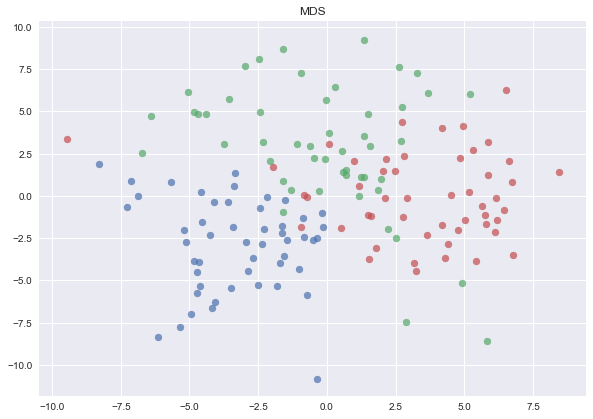

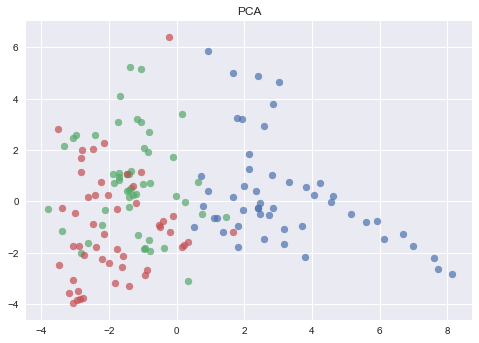

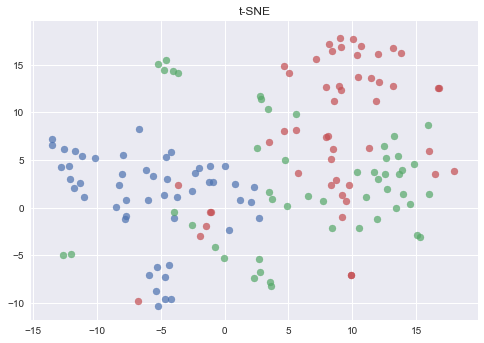

<Figure size 576x396 with 0 Axes>

In [29]:
from sklearn import manifold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

plt.style.use('seaborn')

scaler = StandardScaler()

n_components = 2

tsne = manifold.TSNE(n_components=n_components, perplexity=20, n_iter=2000)
pca = PCA(n_components=n_components)
mds = manifold.MDS(n_components=n_components)

featureDict, labels, featureNames = analyseSounds(datasetPath, timbreClasses, reAnalyse=False, featureSet=gfccTemporalSpectralFeatures)

features = []

noOfInstances = 50

kicks = featureDict["kicks"]
shuffle(kicks)
snares = featureDict["snares"]
shuffle(snares)
hats = featureDict["hats"]
shuffle(hats)

features += kicks[:noOfInstances]
features += snares[:noOfInstances]
features += hats[:noOfInstances]

features = scaler.fit_transform(features)

tsnePoints = tsne.fit_transform(features)
pcaPoints = pca.fit_transform(features)
mdsPoints = mds.fit_transform(features)

# plt.figure(figsize=(6.9, 9.8))

plt.figure(figsize=(9.8, 6.9))

# plt.subplot(131)
plt.title("MDS")
plotFeatures(mdsPoints[:noOfInstances], label="kick")
plotFeatures(mdsPoints[noOfInstances:(noOfInstances*2)], label="snare")
plotFeatures(mdsPoints[(noOfInstances*2):], label="hat")

# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.savefig("MDS.pdf", bbox_inches='tight', dpi=1200)
plt.show()

# plt.subplot(132)
plt.title("PCA")
plotFeatures(pcaPoints[:noOfInstances], label="kick")
plotFeatures(pcaPoints[noOfInstances:(noOfInstances*2)], label="snare")
plotFeatures(pcaPoints[(noOfInstances*2):], label="hat")

# plt.legend()
plt.savefig("PCA.pdf", bbox_inches='tight', dpi=1200)
plt.show()

# plt.subplot(133)
plt.title("t-SNE")
plotFeatures(tsnePoints[:noOfInstances], label="kick")
plotFeatures(tsnePoints[noOfInstances:(noOfInstances*2)], label="snare")
plotFeatures(tsnePoints[(noOfInstances*2):], label="hat")

# plt.legend()
plt.savefig("TSNE.pdf", bbox_inches='tight', dpi=1200)
plt.show()

# plt.legend()
plt.savefig("dimension_reductions.pdf", bbox_inches='tight', dpi=1200)
plt.show()